In [1]:
import os, time, glob
from pathlib import Path
from typing import Optional, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams["axes.grid"] = True

TS_COL = "Timestamp"
_TS_FMT = "%m:%d:%Y %H:%M:%S:%f"


In [2]:

SILVER_DIR  = Path(r"C:\Users\Ishaan Tiwari\Desktop\Kafka\silver")
SCORES_DIR  = SILVER_DIR / "scores"
PATTERN_DIR = SILVER_DIR / "anomalies_pattern"
CONTR_P_DIR = SILVER_DIR / "contribs_point"
METRICS_DIR = SILVER_DIR / "metrics"

for d in [SCORES_DIR, PATTERN_DIR, CONTR_P_DIR, METRICS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def silver_counts():
    print("scores  :", len(list(SCORES_DIR.rglob("*.parquet"))))
    print("patterns:", len(list(PATTERN_DIR.rglob("*.parquet"))))
    print("contribs:", len(list(CONTR_P_DIR.rglob("*.parquet"))))
    print("metrics :", len(list(METRICS_DIR.rglob("*.parquet"))))

silver_counts()


scores  : 116
patterns: 14
contribs: 112
metrics : 0


In [3]:
def _read_parquets(paths: List[Path]) -> pd.DataFrame:
    if not paths: return pd.DataFrame()
    return pd.concat([pd.read_parquet(p) for p in paths], ignore_index=True)

def _parse_ts(df: pd.DataFrame, col: str = TS_COL) -> pd.DataFrame:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format=_TS_FMT, errors="coerce")
    return df

def _latest_batch_id() -> Optional[int]:
    files = list(SCORES_DIR.rglob("*.parquet"))
    if not files: return None
    df = _read_parquets(files)
    if "batch_id" not in df.columns: return None
    return int(pd.to_numeric(df["batch_id"], errors="coerce").max())

def load_scores(limit_rows: Optional[int] = None,
                only_latest_batch: bool = False) -> pd.DataFrame:
    files = list(SCORES_DIR.rglob("*.parquet"))
    if not files: return pd.DataFrame()
    df = _read_parquets(files)
    if only_latest_batch and "batch_id" in df.columns:
        bid = pd.to_numeric(df["batch_id"], errors="coerce").max()
        df = df[df["batch_id"] == bid]
    df = _parse_ts(df, TS_COL).sort_values(TS_COL)
    if limit_rows: df = df.tail(limit_rows)
    return df.reset_index(drop=True)

def load_patterns() -> pd.DataFrame:
    files = list(PATTERN_DIR.rglob("*.parquet"))
    if not files: return pd.DataFrame()
    df = _read_parquets(files)
    df = _parse_ts(df, "start_ts")
    df = _parse_ts(df, "end_ts")
    return df.sort_values("start_ts").reset_index(drop=True)

def load_contribs() -> pd.DataFrame:
    files = list(CONTR_P_DIR.rglob("*.parquet"))
    if not files: return pd.DataFrame()
    df = _read_parquets(files)
    df = _parse_ts(df, TS_COL)
    return df

def load_metrics_latest() -> dict:
    files = list(METRICS_DIR.rglob("*.parquet"))
    if not files: return {}
    df = _read_parquets(files)
    df = df.sort_values("processed_at") if "processed_at" in df.columns else df
    return df.iloc[-1].to_dict()


In [4]:
print("Latest batch_id:", _latest_batch_id())
scores_head = load_scores(limit_rows=5, only_latest_batch=False)
display(scores_head.tail(5))

Latest batch_id: 3


,Timestamp,dense_mse,lstm_mse,is_point,base_score,is_pattern,pattern_id,batch_id,processed_at,pctl_thr,roll_med,roll_mad
0,2025-08-21 13:38:18,2.781740,3.005859,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-21 13:38:19,2.854404,2.983991,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-08-21 13:38:20,3.182129,2.998839,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,0.100000,0.200000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,0.100000,0.200000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def show_latest_batch_tail(last_n: int = 10, refresh_every_sec: int = 10):
    try:
        while True:
            clear_output(wait=True)
            bid = _latest_batch_id()
            if bid is None:
                print("No scored data yet."); time.sleep(refresh_every_sec); continue
            df = load_scores(only_latest_batch=True)
            if df.empty:
                print("No scored data yet."); time.sleep(refresh_every_sec); continue
            cols = [TS_COL, "dense_mse", "lstm_mse", "is_point", "is_pattern", "pattern_id",
                    "batch_id", "processed_at"]
            cols = [c for c in cols if c in df.columns]
            display(df.tail(last_n)[cols])
            print(f"(Latest batch_id={bid} • updating every {refresh_every_sec}s)")
            time.sleep(refresh_every_sec)
    except KeyboardInterrupt:
        print("Stopped live tail.")


def show_latest_batch_tail_once(last_n: int = 10):
    bid = _latest_batch_id()
    if bid is None:
        print("No scored data yet."); return
    df = load_scores(only_latest_batch=True)
    cols = [TS_COL, "dense_mse", "lstm_mse", "is_point", "is_pattern", "pattern_id",
            "batch_id", "processed_at"]
    cols = [c for c in cols if c in df.columns]
    display(df.tail(last_n)[cols])


show_latest_batch_tail_once(10)


,Timestamp,dense_mse,lstm_mse,is_point,is_pattern,pattern_id,batch_id,processed_at
1990,2025-08-21 13:00:32,3.664060,2.975407,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1991,2025-08-21 13:00:33,2.542423,2.968219,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1992,2025-08-21 13:00:34,2.666021,2.958745,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1993,2025-08-21 13:00:35,3.415523,2.957977,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1994,2025-08-21 13:00:36,3.000982,2.972914,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1995,2025-08-21 13:00:37,3.512613,2.993061,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1996,2025-08-21 13:00:38,3.446550,2.992289,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1997,2025-08-21 13:00:39,3.417509,3.000011,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1998,2025-08-21 13:00:40,4.099998,3.047994,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00
1999,2025-08-21 13:00:41,3.578324,3.055083,False,False,NaN,3.0,2025-08-21T09:55:13.625750+00:00


In [6]:
def _base_score_series(df: pd.DataFrame) -> pd.Series:
    lstm = df["lstm_mse"] if "lstm_mse" in df.columns else pd.Series(index=df.index, dtype=float)
    dense = df["dense_mse"] if "dense_mse" in df.columns else pd.Series(index=df.index, dtype=float)
    return np.where(np.isfinite(lstm), lstm, dense)

def _latest_threshold(df: pd.DataFrame) -> float:
    m = load_metrics_latest()
    if "pctl_thr" in m and pd.notnull(m["pctl_thr"]):
        return float(m["pctl_thr"])
    bs = _base_score_series(df)
    if len(bs) == 0: return np.inf
    return float(np.nanpercentile(bs, 99))


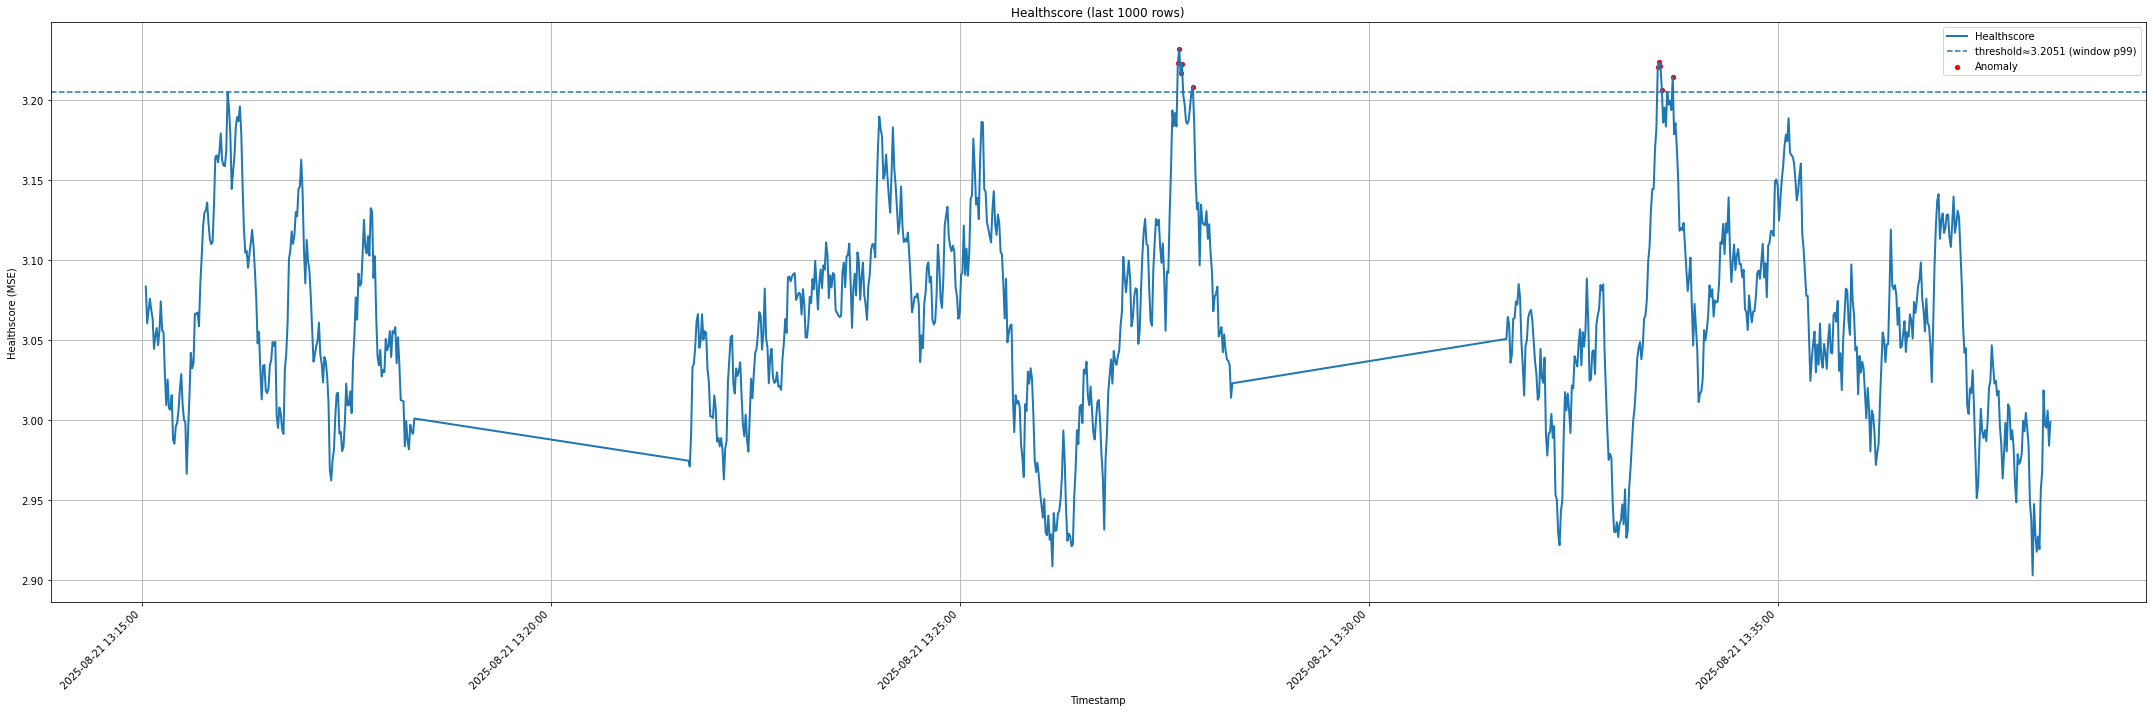

In [7]:
import matplotlib.dates as mdates

def plot_healthscore(
    window_rows: int = 2000,
    log_y: bool = False,
    title: str = "Healthscore"
):
   
    df = load_scores(limit_rows=window_rows, only_latest_batch=False)
    if df.empty:
        print("No scored data yet.")
        return pd.DataFrame(), np.nan

    df = df.copy()
    df["base_score"] = _base_score_series(df)

    thr_metrics = load_metrics_latest()
    if "pctl_thr" in thr_metrics and pd.notnull(thr_metrics["pctl_thr"]):
        thr = float(thr_metrics["pctl_thr"])
        thr_src = "metrics"
    else:
        thr = float(np.nanpercentile(df["base_score"].to_numpy(), 99))
        thr_src = "window p99"

    if TS_COL in df.columns and not np.issubdtype(df[TS_COL].dtype, np.datetime64):
        df[TS_COL] = pd.to_datetime(df[TS_COL], format=_TS_FMT, errors="coerce")
    x = df[TS_COL] if TS_COL in df.columns else np.arange(len(df))

    fig, ax = plt.subplots()
    ax.plot(x, df["base_score"].values, linewidth=2, label="Healthscore")

    if "is_point" in df.columns:
        pts = df[df["is_point"].astype(bool)]
        if not pts.empty:
            ax.scatter(
                pts[TS_COL] if TS_COL in pts.columns else pts.index,
                pts["base_score"].values,
                s=18, marker="o", label="Anomaly", color="red"
            )

    if np.isfinite(thr):
        ax.axhline(thr, linestyle="--", label=f"threshold≈{thr:.4f} ({thr_src})")

    if TS_COL in df.columns:
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
        fig.autofmt_xdate(rotation=45)

    ax.set_title(f"{title} (last {len(df)} rows)")
    ax.set_xlabel(TS_COL if TS_COL in df.columns else "row index")
    ax.set_ylabel("Healthscore (MSE)")
    if log_y:
        ax.set_yscale("log")
    ax.legend()
    plt.tight_layout()
    plt.show()

    #return df, thr

plot_healthscore(window_rows=1000)

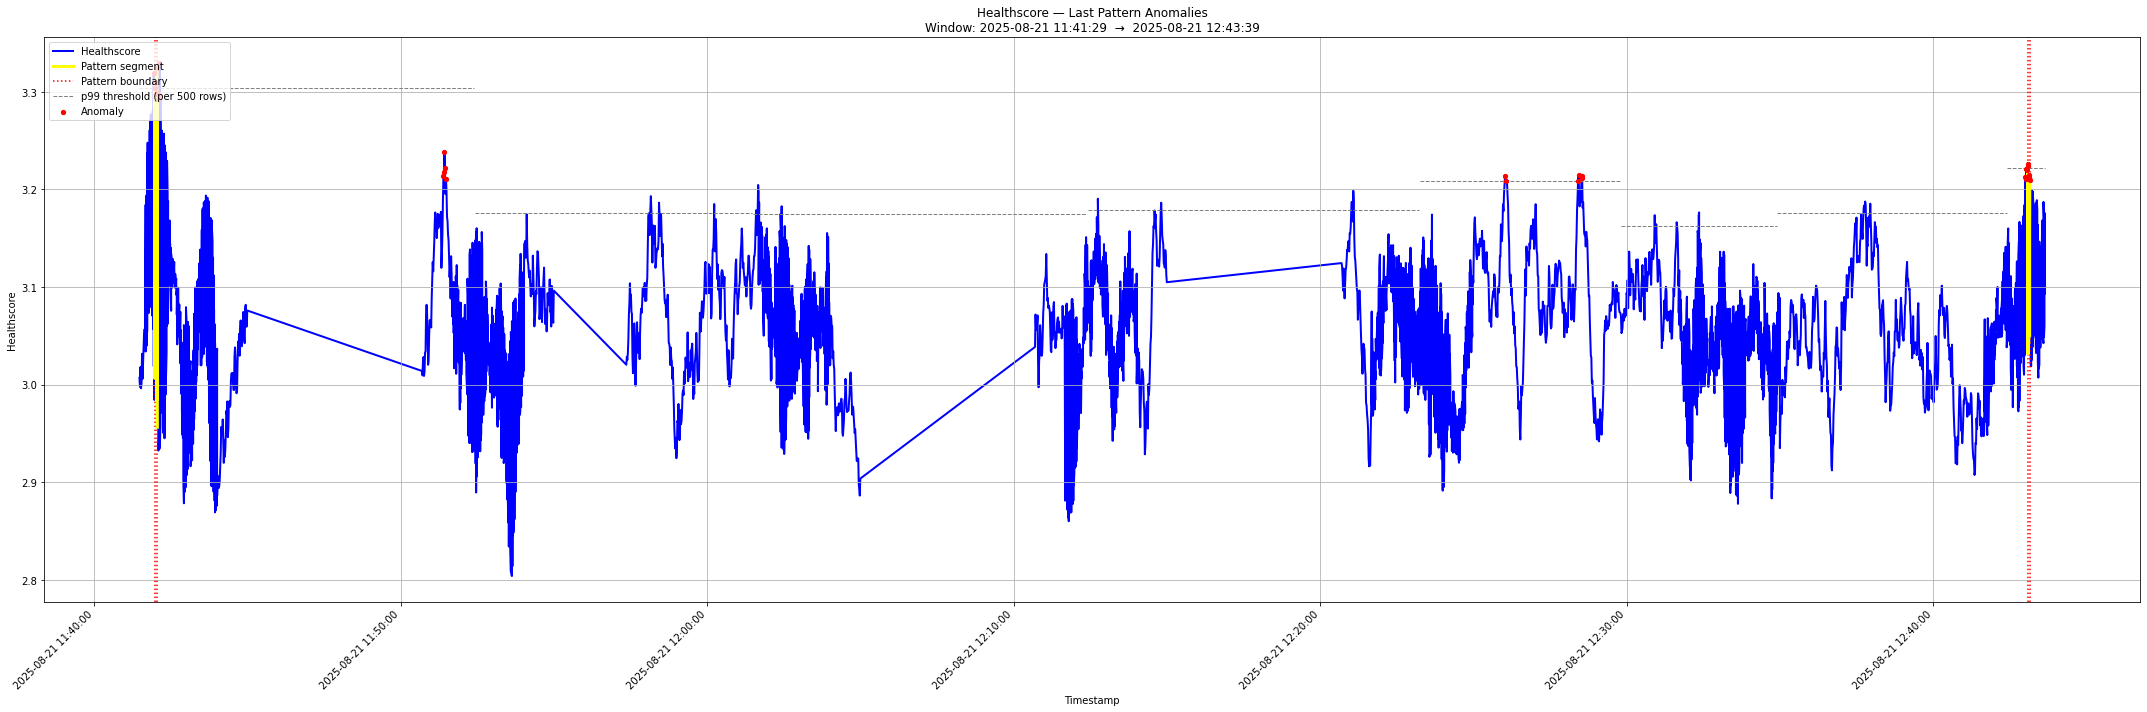

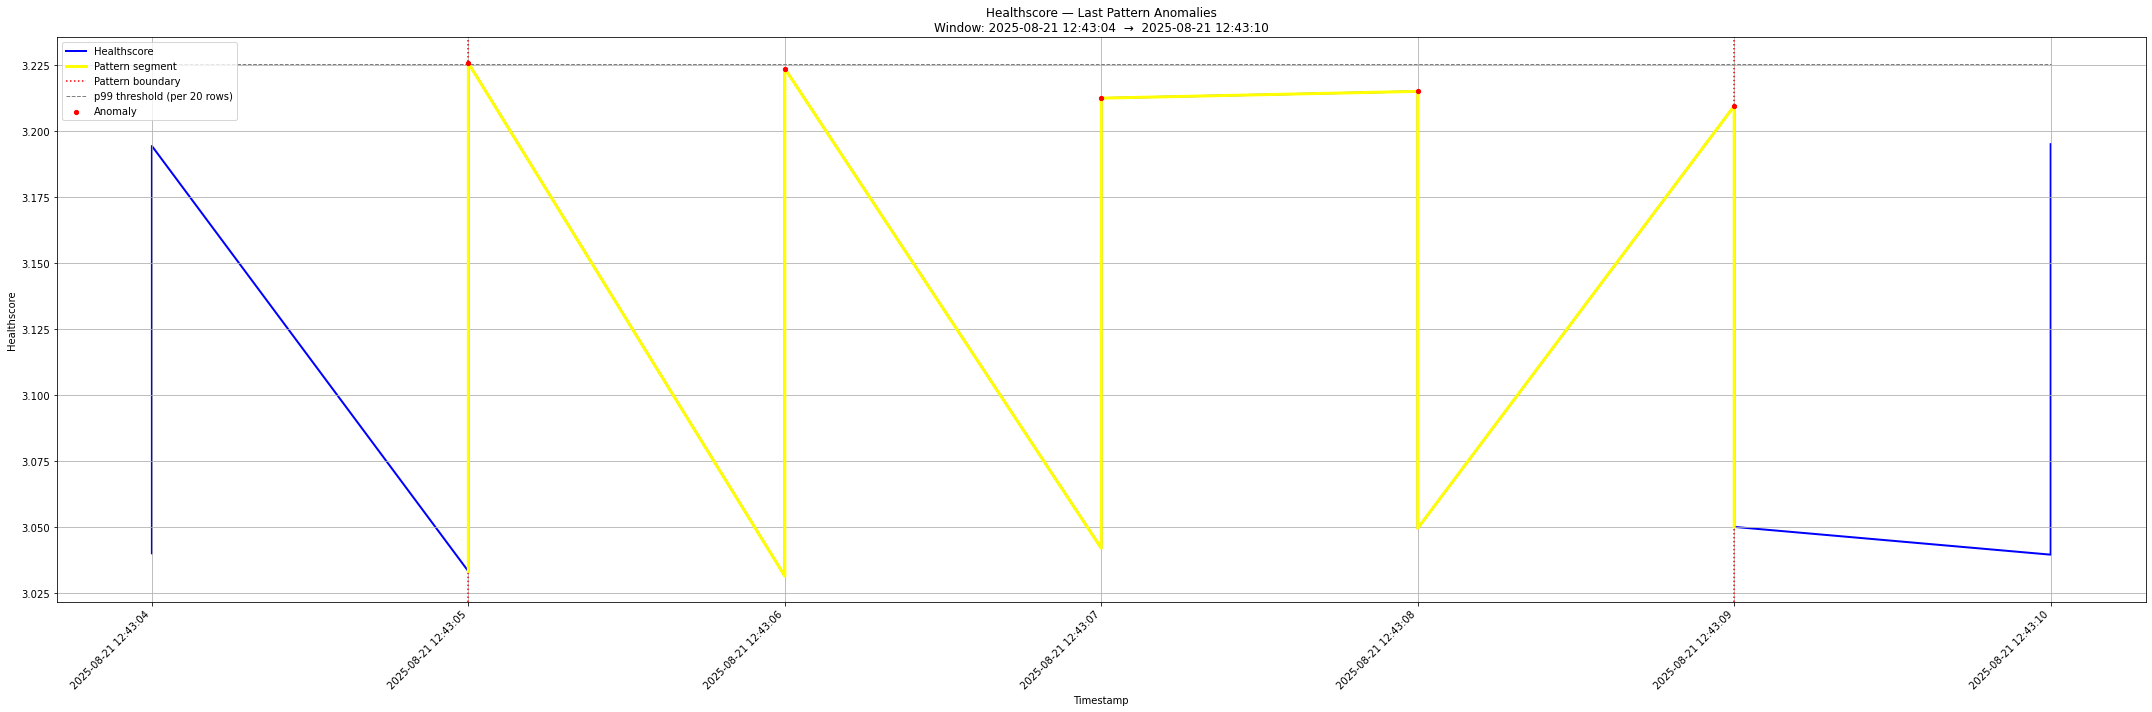

In [8]:
# %% C8 (REPLACEMENT)
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_lastN_pattern_window(
    max_patterns: int = 3,
    pad: str = "1min",
    thr_chunk: int = 1000,            
    title: str = "Healthscore — Last Pattern Anomalies"
):
   
    def parse_dt(df_in: pd.DataFrame, col: str) -> pd.DataFrame:
        if col in df_in.columns and not np.issubdtype(df_in[col].dtype, np.datetime64):
            ts_try = pd.to_datetime(df_in[col], format=_TS_FMT, errors="coerce")
            if ts_try.isna().sum() > len(ts_try) // 2:  
                ts_try = pd.to_datetime(df_in[col], errors="coerce")
            df_in = df_in.copy()
            df_in[col] = ts_try
        return df_in

    def drop_nat(df_in: pd.DataFrame, col: str) -> pd.DataFrame:
        if col not in df_in.columns:
            return df_in
        return (df_in[df_in[col].notna()]
                .sort_values(col)
                .reset_index(drop=True))

    
    pat = load_patterns()
    if pat.empty:
        print("No pattern anomalies found — plotting healthscore normally.")
        plot_healthscore(window_rows=1200, title="Healthscore (no pattern anomalies)")
        return

    pat = parse_dt(pat, "start_ts")
    pat = parse_dt(pat, "end_ts")
    pat = drop_nat(drop_nat(pat, "start_ts"), "end_ts")
    if pat.empty:
        print("No valid pattern timestamps — plotting healthscore normally.")
        plot_healthscore(window_rows=1200, title="Healthscore (no valid pattern timestamps)")
        return

    
    pat_sorted = pat.sort_values("end_ts")
    n_avail = len(pat_sorted)
    n_use = min(max_patterns, n_avail)
    if n_use == 0:
        print("No pattern anomalies found — plotting healthscore normally.")
        plot_healthscore(window_rows=1200, title="Healthscore (no pattern anomalies)")
        return
    if n_use < max_patterns:
        print(f"Only {n_use} pattern anomaly/anomalies found; plotting those.")

    pat_sel = pat_sorted.tail(n_use)

    
    win_start = pat_sel["start_ts"].min() - pd.Timedelta(pad)
    win_end   = pat_sel["end_ts"].max()   + pd.Timedelta(pad)

    
    df_full = load_scores(limit_rows=None, only_latest_batch=False)
    if df_full.empty:
        print("No scores available — cannot plot.")
        return

    df_full = parse_dt(df_full, TS_COL)
    df_full = drop_nat(df_full, TS_COL)
    df_win = df_full[(df_full[TS_COL] >= win_start) & (df_full[TS_COL] <= win_end)].copy()
    if df_win.empty:
        print("No score rows in the computed pattern window — plotting healthscore normally.")
        plot_healthscore(window_rows=1200, title="Healthscore (window empty)")
        return

   
    df_win["base_score"] = _base_score_series(df_win)

   
    fig, ax = plt.subplots()
    x = df_win[TS_COL].to_numpy()
    y = df_win["base_score"].to_numpy()
    ax.plot(x, y, linewidth=2, color="blue", label="Healthscore", zorder=1)

    
    added_yellow_label = False
    added_vline_label = False
    for row in pat_sel.itertuples(index=False):
        p_start = getattr(row, "start_ts")
        p_end   = getattr(row, "end_ts")
       
        mask = (df_win[TS_COL] >= p_start) & (df_win[TS_COL] <= p_end)
        if mask.any():
            x_seg = df_win.loc[mask, TS_COL].to_numpy()
            y_seg = df_win.loc[mask, "base_score"].to_numpy()
            ax.plot(
                x_seg, y_seg, linewidth=3, color="yellow",
                label=("Pattern segment" if not added_yellow_label else None), zorder=3
            )
            added_yellow_label = True
        
        ax.axvline(p_start, linestyle=":", color="red", linewidth=1.5,
                   label=("Pattern boundary" if not added_vline_label else None), zorder=2)
        ax.axvline(p_end,   linestyle=":", color="red", linewidth=1.5, zorder=2)
        added_vline_label = True

    
    n = len(df_win)
    added_thr_label = False
    if thr_chunk and thr_chunk > 0 and n > 0:
        for i in range(0, n, thr_chunk):
            j = min(i + thr_chunk, n)
            y_chunk = df_win["base_score"].iloc[i:j].to_numpy()
            if np.isfinite(y_chunk).sum() == 0:
                continue
            thr_val = float(np.nanpercentile(y_chunk, 99))
            
            x_start = x[i]
            x_end   = x[j-1]
            ax.plot([x_start, x_end], [thr_val, thr_val],
                    linestyle="--", linewidth=1,
                    color="gray",
                    label=("p99 threshold (per {} rows)".format(thr_chunk) if not added_thr_label else None),
                    zorder=2)
            added_thr_label = True

    
    if "is_point" in df_win.columns:
        pts = df_win[df_win["is_point"].astype(bool)]
        if not pts.empty:
            ax.scatter(pts[TS_COL].to_numpy(), pts["base_score"].to_numpy(),
                       s=18, color="red", marker="o", label="Anomaly", zorder=4)

   
    ax.set_title(f"{title}\nWindow: {win_start}  →  {win_end}")
    ax.set_xlabel(TS_COL)
    ax.set_ylabel("Healthscore")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
    fig.autofmt_xdate(rotation=45)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


plot_lastN_pattern_window(max_patterns=2, pad="30sec", thr_chunk=500)
plot_lastN_pattern_window(max_patterns=1, pad="1sec", thr_chunk=20)


In [9]:
def topk_point_anomalies(k: int = 10) -> pd.DataFrame:
    df = load_scores(limit_rows=None, only_latest_batch=False)
    if df.empty or "is_point" not in df.columns:
        return pd.DataFrame()
    df["base_score"] = _base_score_series(df)
    pts = df[df["is_point"].astype(bool)].copy()
    pts = pts.sort_values("base_score", ascending=False).head(k)
    keep = [TS_COL, "base_score", "dense_mse", "lstm_mse", "is_pattern", "pattern_id", "batch_id", "processed_at"]
    keep = [c for c in keep if c in pts.columns]
    return pts[keep].reset_index(drop=True)

def topk_pattern_anomalies(k: int = 10) -> pd.DataFrame:
    pat = load_patterns()
    if pat.empty:
        return pd.DataFrame()
    score_cols = [c for c in ["max_base_score", "mean_base_score", "length"] if c in pat.columns]
    if "max_base_score" in score_cols:
        pat_top = pat.sort_values(["max_base_score", "length"], ascending=[False, False]).head(k)
    else:
        pat_top = pat.sort_values("length", ascending=False).head(k)
    return pat_top.reset_index(drop=True)

display(topk_point_anomalies(10))
display(topk_pattern_anomalies(10))

,Timestamp,base_score,dense_mse,lstm_mse,is_pattern,pattern_id,batch_id,processed_at
0,2025-08-20 22:26:15,4.159948,4.159948,NaN,NaN,NaN,NaN,NaN
1,2025-08-20 22:26:33,3.646133,3.646133,NaN,NaN,NaN,NaN,NaN
2,2025-08-20 22:26:36,3.627645,3.627645,NaN,NaN,NaN,NaN,NaN
3,2025-08-20 22:26:16,3.574626,3.574626,NaN,NaN,NaN,NaN,NaN
4,2025-08-20 22:26:20,3.491332,3.491332,NaN,NaN,NaN,NaN,NaN
5,2025-08-20 22:26:31,3.423111,3.423111,NaN,NaN,NaN,NaN,NaN
6,2025-08-20 22:26:09,3.419050,3.419050,NaN,NaN,NaN,NaN,NaN
7,2025-08-20 22:26:37,3.410758,3.410758,NaN,NaN,NaN,NaN,NaN
8,2025-08-20 22:26:21,3.407423,3.407423,NaN,NaN,NaN,NaN,NaN
9,2025-08-21 11:42:08,3.329480,3.574872,3.32948,NaN,NaN,NaN,NaN


,pattern_id,start_ts,end_ts,length,max_base_score,mean_base_score
0,1755770065098,2025-08-21 10:56:47,2025-08-21 10:56:57,11,3.317979,3.267868
1,1755770089445,2025-08-21 11:22:34,2025-08-21 11:22:38,5,3.234924,3.224442
2,1755770113606,2025-08-21 12:43:05,2025-08-21 12:43:09,5,3.225644,3.217184
3,1755729918304,2025-08-21 05:04:29,2025-08-21 05:04:35,7,NaN,NaN
4,1755730130461,2025-08-21 10:54:05,2025-08-21 10:54:11,7,NaN,NaN
5,1755730161504,2025-08-21 11:41:59,2025-08-21 11:42:04,6,NaN,NaN
6,1755730099279,2025-08-21 09:03:05,2025-08-21 09:03:09,5,NaN,NaN


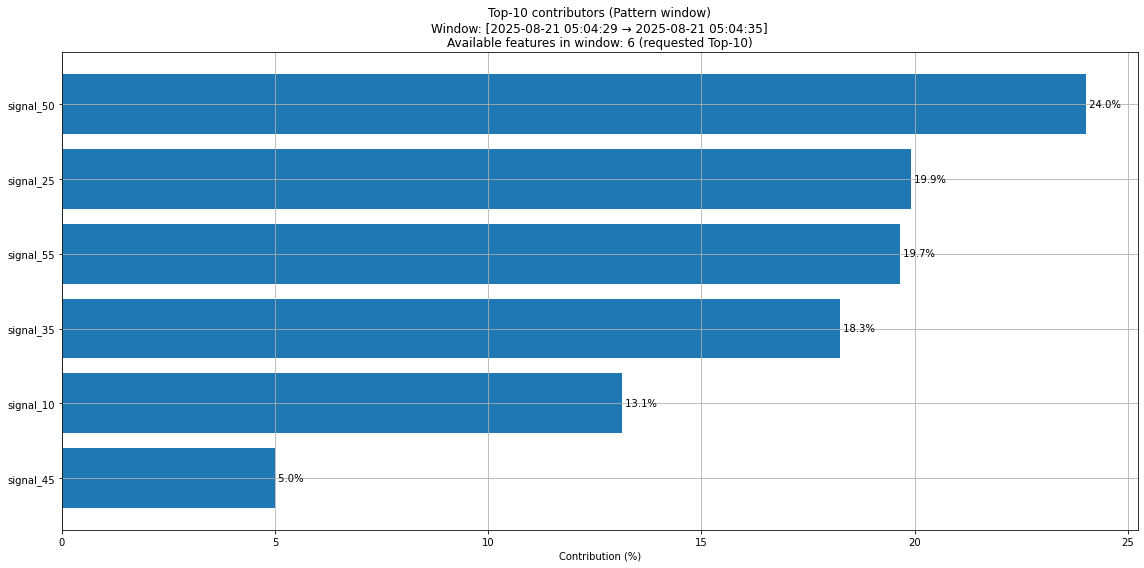

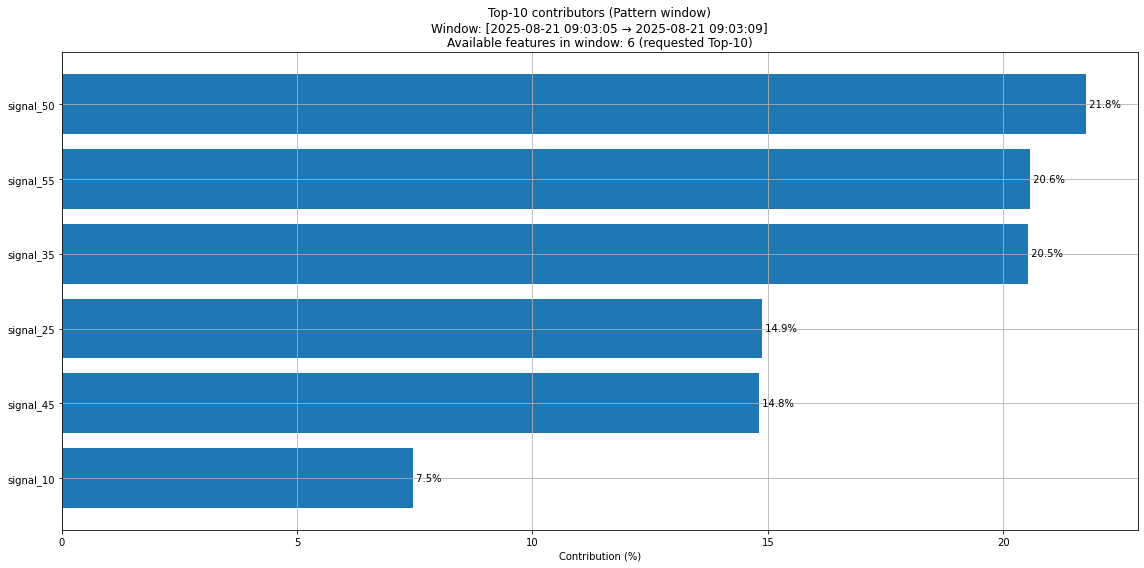

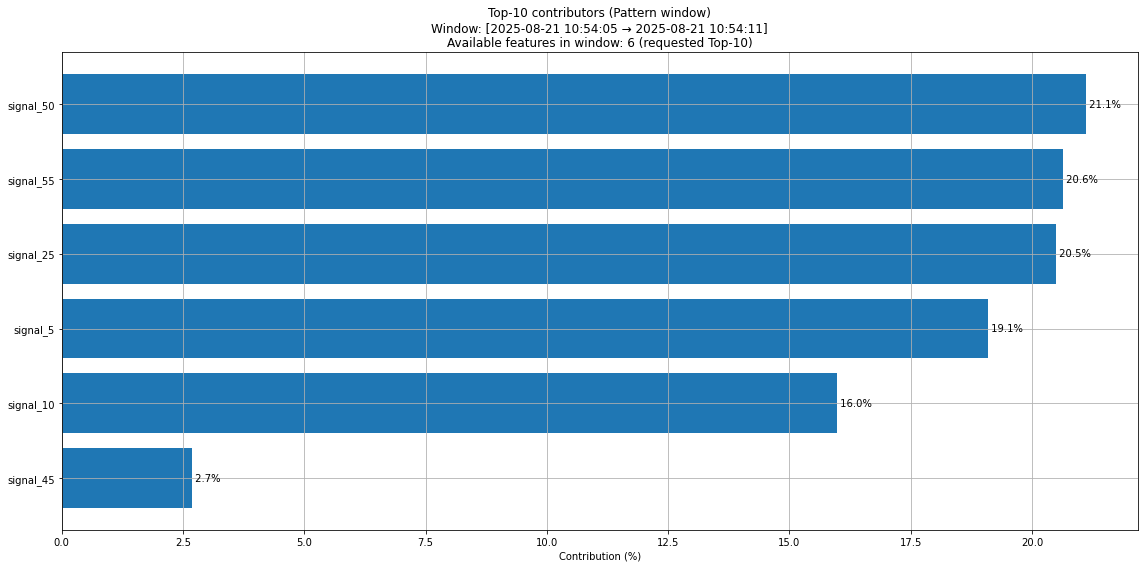

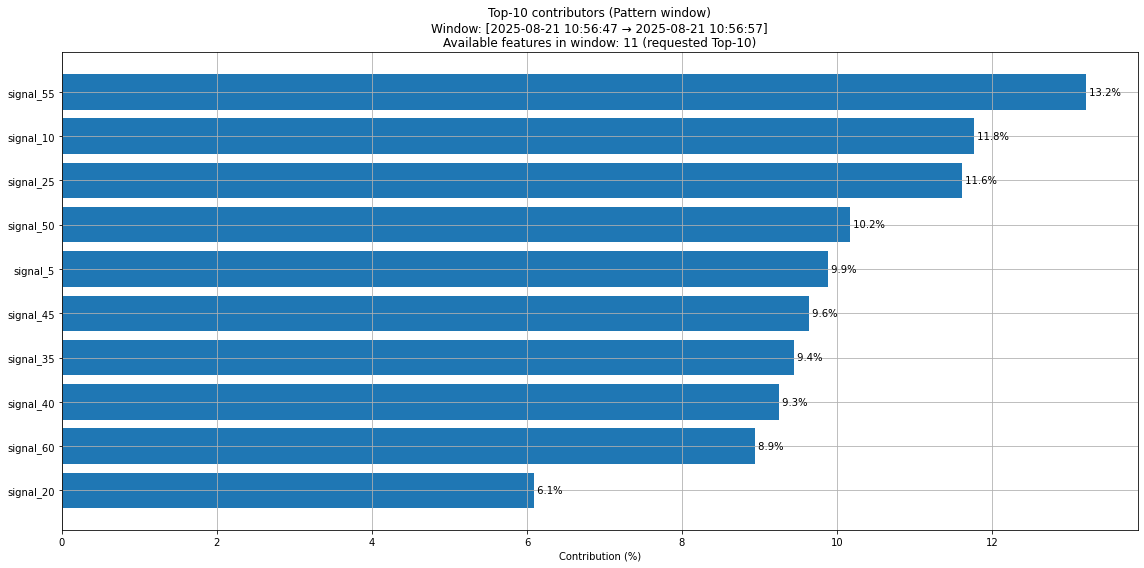

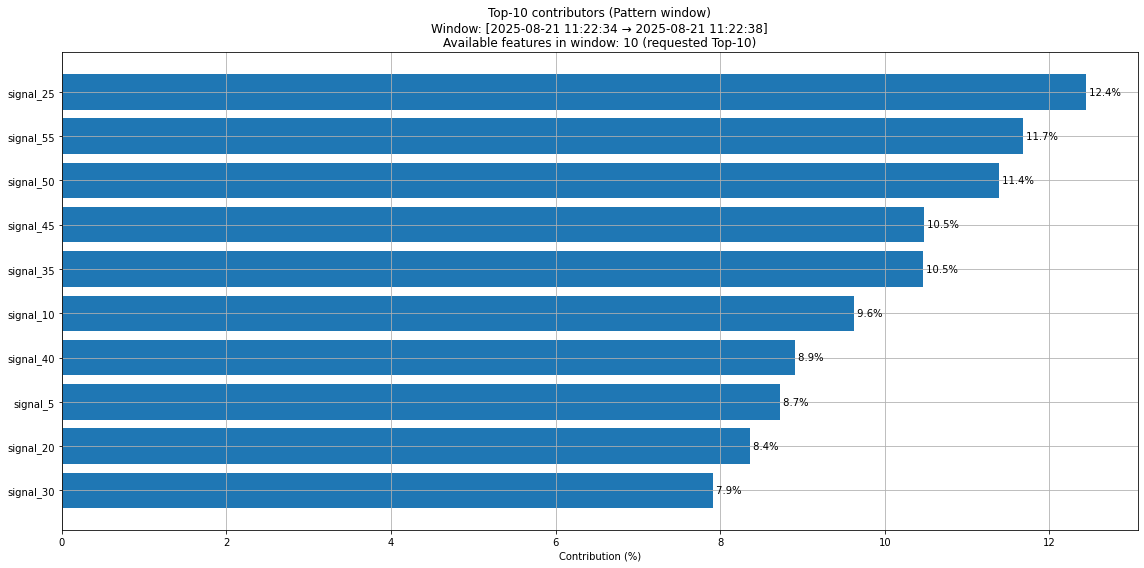

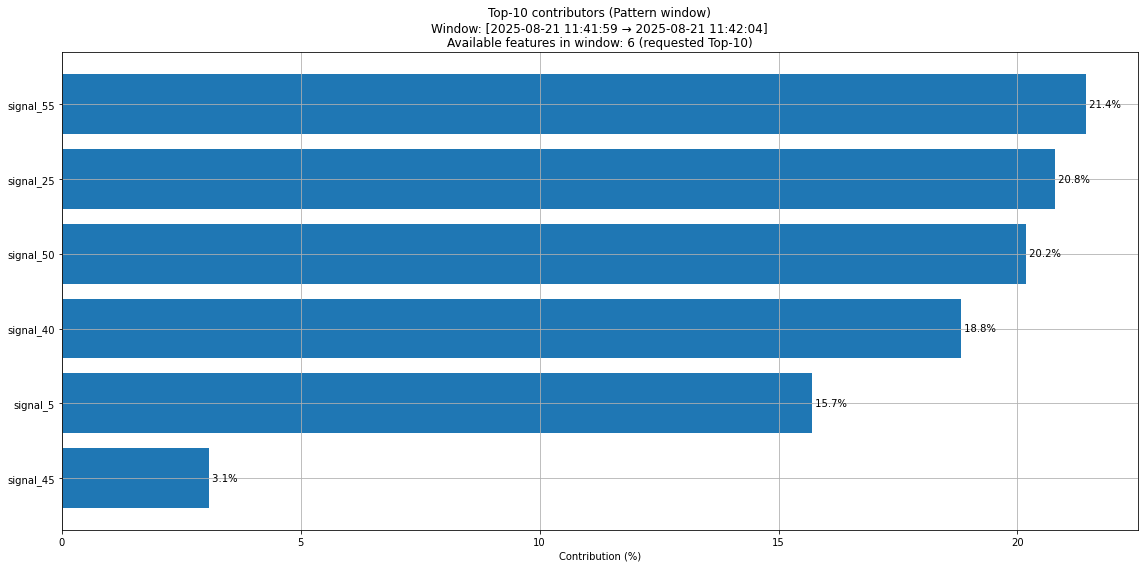

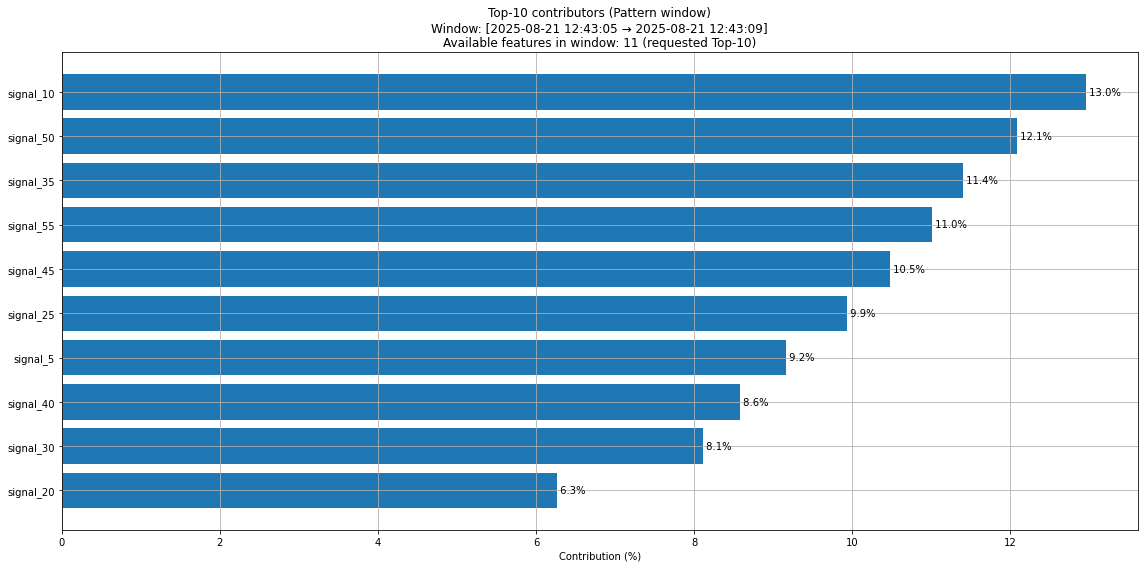

In [10]:

import matplotlib.dates as mdates

def plot_pattern_anomaly_contributors(
    num_patterns: int = 3,
    topn_feats: int = 10,
    use_abs: bool = True,         
    normalize: bool = True,       
    title_prefix: str = "Top-{topn} contributors (Pattern window)"
):
    
    def _parse_dt(df_in: pd.DataFrame, col: str) -> pd.DataFrame:
        if col in df_in.columns and not np.issubdtype(df_in[col].dtype, np.datetime64):
            ts_try = pd.to_datetime(df_in[col], format=_TS_FMT, errors="coerce")
            if ts_try.isna().sum() > len(ts_try) // 2:
                ts_try = pd.to_datetime(df_in[col], errors="coerce")
            df_in = df_in.copy()
            df_in[col] = ts_try
        return df_in

    def _drop_nat(df_in: pd.DataFrame, col: str) -> pd.DataFrame:
        if col not in df_in.columns:
            return df_in
        return (df_in[df_in[col].notna()]
                .sort_values(col)
                .reset_index(drop=True))

    
    pat = load_patterns()
    if pat.empty:
        print("No pattern anomalies found.")
        return
    pat = _parse_dt(pat, "start_ts")
    pat = _parse_dt(pat, "end_ts")
    pat = _drop_nat(_drop_nat(pat, "start_ts"), "end_ts")
    if pat.empty:
        print("No valid pattern timestamps.")
        return

 
    pat_sel = pat.sort_values("end_ts").tail(max(1, num_patterns))

    
    dfc = load_contribs()
    if dfc.empty:
        print("No contributions available.")
        return
    if TS_COL in dfc.columns and not np.issubdtype(dfc[TS_COL].dtype, np.datetime64):
        dfc[TS_COL] = pd.to_datetime(dfc[TS_COL], format=_TS_FMT, errors="coerce")
        
        if dfc[TS_COL].isna().sum() > len(dfc) // 2:
            dfc[TS_COL] = pd.to_datetime(dfc[TS_COL], errors="coerce")
    dfc = _drop_nat(dfc, TS_COL)

    
    for row in pat_sel.itertuples(index=False):
        p_start = getattr(row, "start_ts")
        p_end   = getattr(row, "end_ts")
        
        mask = (dfc[TS_COL] >= p_start) & (dfc[TS_COL] <= p_end)
        sub = dfc.loc[mask]
        if sub.empty:
            print(f"No contributions found in window [{p_start} → {p_end}]. Skipping.")
            continue

        
        g = sub.groupby("feature")["contribution"]
        agg = (g.apply(lambda s: s.abs().sum()) if use_abs else g.sum()).sort_values(ascending=False)
        available = len(agg)
        want = topn_feats
        note = f"Available features in window: {available} (requested Top-{want})"

        
        agg = agg.head(topn_feats)

        
        if normalize:
            denom = float(agg.abs().sum()) if use_abs else float(agg.abs().sum())
            if denom > 0:
                agg = (agg / denom) * 100.0

        
        labels = agg.index.tolist()[::-1]
        values = agg.values.tolist()[::-1]

        
        title = title_prefix.format(topn=topn_feats)
        win_str = f"[{p_start} → {p_end}]"
        plt.figure(figsize=(16, 8))  
        plt.barh(labels, values)
        if normalize:
            plt.xlabel("Contribution (%)")
            plt.title(f"{title_prefix.format(topn=topn_feats)}\nWindow: [{p_start} → {p_end}]\n{note}")
        else:
            plt.xlabel("Contribution")
            plt.title(f"{title_prefix.format(topn=topn_feats)}\nWindow: [{p_start} → {p_end}]\n{note}")

        
        ax = plt.gca()
        for i, v in enumerate(values):
            ax.text(v, i, f" {v:.1f}%" if normalize else f" {v:.3g}", va="center")

        plt.tight_layout()
        plt.show()


plot_pattern_anomaly_contributors(
    num_patterns = 10,
    topn_feats = 10,
)

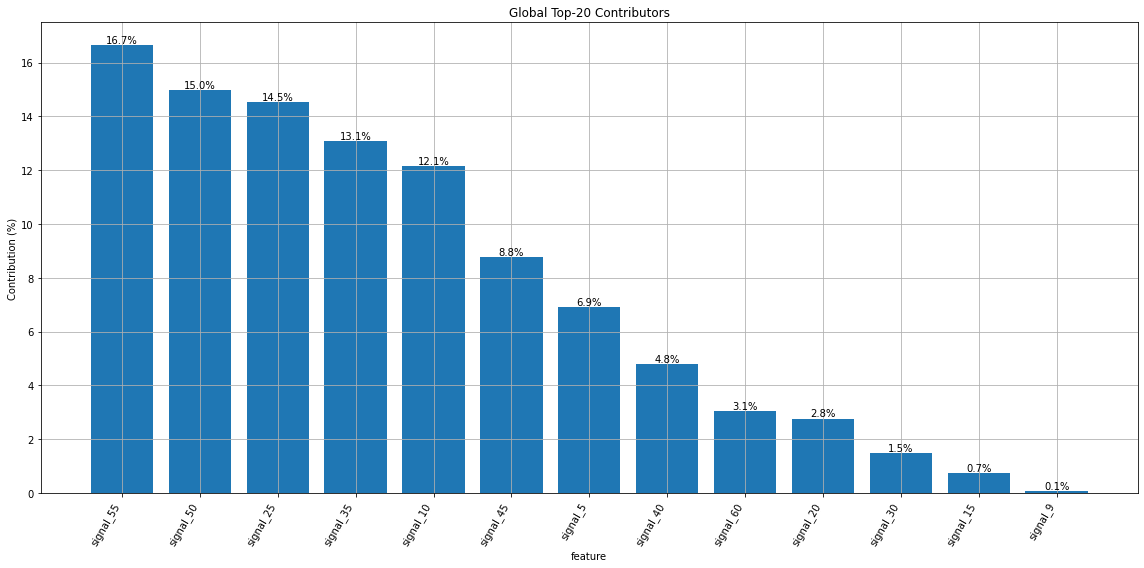

In [11]:
def plot_global_contributors(
    topn: int = 20,
    use_abs: bool = True,          
    normalize: bool = True,        
    anomalies_only: bool = False,  
    confirmed_only: bool = False, 
    title: str = "Global Top-{topn} Contributors"
):
    
    dfc = load_contribs()
    if dfc.empty:
        print("No contributions yet.")
        return

    
    if TS_COL in dfc.columns and not np.issubdtype(dfc[TS_COL].dtype, np.datetime64):
        ts_try = pd.to_datetime(dfc[TS_COL], format=_TS_FMT, errors="coerce")
        if ts_try.isna().sum() > len(ts_try) // 2: 
            ts_try = pd.to_datetime(dfc[TS_COL], errors="coerce")
        dfc = dfc.copy()
        dfc[TS_COL] = ts_try
    if TS_COL in dfc.columns:
        dfc = dfc[dfc[TS_COL].notna()]

    
    if anomalies_only or confirmed_only:
        dfs = load_scores(limit_rows=None, only_latest_batch=False)
        if dfs.empty or TS_COL not in dfs.columns:
            print("Warning: could not load scores with timestamps; showing all contributions.")
        else:
            if not np.issubdtype(dfs[TS_COL].dtype, np.datetime64):
                dfs[TS_COL] = pd.to_datetime(dfs[TS_COL], format=_TS_FMT, errors="coerce")
                if dfs[TS_COL].isna().sum() > len(dfs) // 2:
                    dfs[TS_COL] = pd.to_datetime(dfs[TS_COL], errors="coerce")
            dfs = dfs[dfs[TS_COL].notna()]

            
            mask = pd.Series(True, index=dfs.index)
            if confirmed_only and {"is_point", "is_pattern"}.issubset(dfs.columns):
                mask = dfs["is_point"].astype(bool) & dfs["is_pattern"].astype(bool)
            elif anomalies_only and "is_point" in dfs.columns:
                mask = dfs["is_point"].astype(bool)
            else:
                pass

            ts_keep = set(dfs.loc[mask, TS_COL].unique())
            if len(ts_keep) == 0:
                print("No matching anomaly timestamps; nothing to plot.")
                return
            dfc = dfc[dfc[TS_COL].isin(ts_keep)]

    if dfc.empty:
        print("No contributions to aggregate after filtering.")
        return

    
    g = dfc.groupby("feature")["contribution"]
    agg = (g.apply(lambda s: s.abs().sum()) if use_abs else g.sum())
    agg = agg.sort_values(ascending=False).head(topn)

    if agg.empty:
        print("No contributions to display.")
        return

    
    y_label = "sum(|contribution|)" if use_abs else "sum(contribution)"
    if normalize:
        total = float(agg.abs().sum()) if use_abs else float(agg.abs().sum())
        if total > 0:
            agg = (agg / total) * 100.0
            y_label = "Contribution (%)"

    
    labels = agg.index.tolist()
    values = agg.values.tolist()

    plt.figure(figsize = (16,8))
    plt.bar(labels, values)
    plt.xticks(rotation=60, ha="right")
    ttl = title.format(topn=topn)
    if confirmed_only:
        ttl += " — Confirmed anomalies"
    elif anomalies_only:
        ttl += " — Anomalies only"
    plt.title(ttl)
    plt.xlabel("feature")
    plt.ylabel(y_label)
    plt.tight_layout()

    
    ax = plt.gca()
    for i, v in enumerate(values):
        ax.text(i, v, f"{v:.1f}%" if normalize else f"{v:.3g}", ha="center", va="bottom")

    plt.show()

plot_global_contributors(20)

In [12]:
def plot_contrib_heatmap_topk(
    top_k_points: int = 20,
    top_global_feats: int = 15,
    confirmed_only: bool = False,
    normalize: bool = True,
    fmt: str = ".1f"
):
    import numpy as np
    import matplotlib.pyplot as plt

    pts = topk_point_anomalies(top_k_points)
    if pts.empty:
        print("Need anomalies to build the heatmap — none found.")
        return
    if confirmed_only and {"is_point", "is_pattern"}.issubset(pts.columns):
        pts = pts[pts["is_point"].astype(bool) & pts["is_pattern"].astype(bool)]
        if pts.empty:
            print("No confirmed anomalies among top points.")
            return
    if TS_COL in pts.columns and not np.issubdtype(pts[TS_COL].dtype, np.datetime64):
        pts[TS_COL] = pd.to_datetime(pts[TS_COL], format=_TS_FMT, errors="coerce")
    pts = pts[TS_COL].dropna()
    ts_list = pts.tolist()

    dfc = load_contribs()
    if dfc.empty:
        print("No contributions available.")
        return
    if TS_COL in dfc.columns and not np.issubdtype(dfc[TS_COL].dtype, np.datetime64):
        ts_try = pd.to_datetime(dfc[TS_COL], format=_TS_FMT, errors="coerce")
        if ts_try.isna().sum() > len(ts_try) // 2:
            ts_try = pd.to_datetime(dfc[TS_COL], errors="coerce")
        dfc[TS_COL] = ts_try
    dfc = dfc.dropna(subset=[TS_COL])

    g_global = dfc.groupby("feature")["contribution"].apply(lambda s: s.abs().sum())
    top_feats = g_global.sort_values(ascending=False).head(top_global_feats).index.tolist()

    df_sub = dfc[dfc[TS_COL].isin(ts_list) & dfc["feature"].isin(top_feats)].copy()
    mat = (df_sub.groupby([TS_COL, "feature"])["contribution"]
                 .sum()
                 .unstack("feature")
                 .reindex(index=ts_list)
                 .reindex(columns=top_feats)).fillna(0.0)

    if normalize:
        row_sums = mat.abs().sum(axis=1)
        row_sums[row_sums == 0] = 1.0
        mat = (mat.T / row_sums).T * 100.0
        vlabel = "Contribution (%)"
    else:
        vlabel = "Contribution"

    fig, ax = plt.subplots(figsize=(16, 8))
    c = ax.pcolormesh(mat.values, cmap="Blues", shading="auto")

    y_labels = [ts.strftime("%Y-%m-%d %H:%M:%S") for ts in mat.index]
    x_labels = mat.columns.tolist()
    ax.set_yticks(np.arange(len(y_labels)) + 0.5)
    ax.set_yticklabels(y_labels)
    ax.set_xticks(np.arange(len(x_labels)) + 0.5)
    ax.set_xticklabels(x_labels, rotation=60, ha="right")

    cb = plt.colorbar(c, ax=ax)
    cb.set_label(vlabel)

    ny, nx = mat.shape
    for i in range(ny):
        for j in range(nx):
            ax.text(j + 0.5, i + 0.5, format(mat.iat[i, j], fmt),
                    ha="center", va="center", fontsize=8, color="black")

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.invert_yaxis()

    ax.set_title(f"Top-{top_global_feats} features × Top-{len(ts_list)} anomalies")
    plt.tight_layout()
    plt.show()


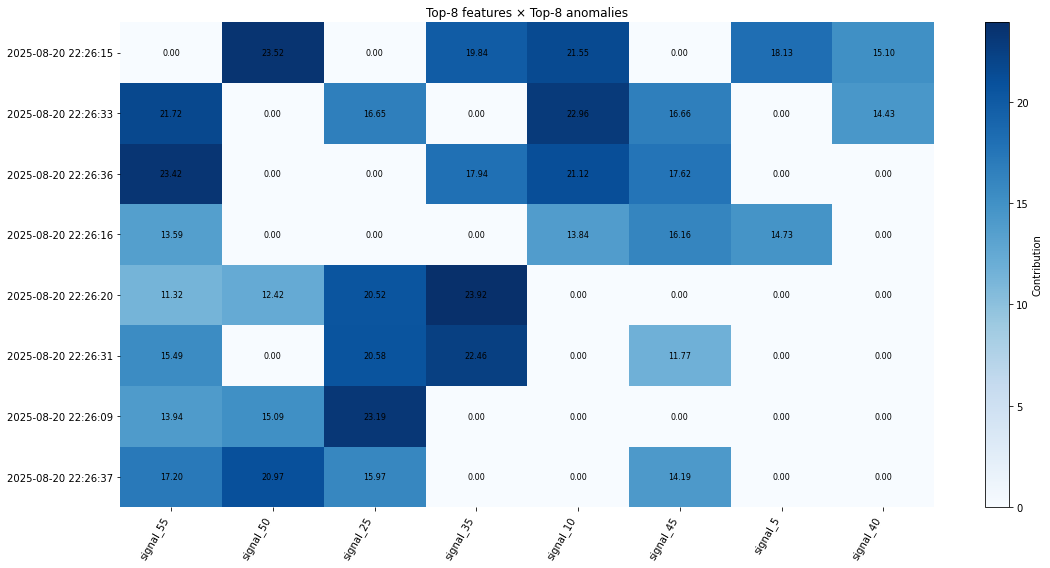

In [13]:
plot_contrib_heatmap_topk( top_k_points = 8,
    top_global_feats = 8,normalize=False, fmt=".2f")

In [14]:
def quick_dashboard(refresh_every_sec: int = 60):
    import time
    from IPython.display import clear_output, display

    try:
        while True:
            clear_output(wait=True)

            print("=== Latest Batch Tail ===")
            show_latest_batch_tail(last_n=10, refresh_every_sec=10)

            print("\n=== Healthscore (window) ===")
            plot_healthscore(window_rows=2000)

            print("\n=== Last Pattern Anomaly Windows ===")
            plot_lastN_pattern_window(max_patterns=3, pad="1min")

            print("\n=== Top-K Point Anomalies ===")
            display(topk_point_anomalies(k=10))

            print("\n=== Top-K Pattern Anomalies ===")
            display(topk_pattern_anomalies(k=10))

            print("\n=== Pattern Anomaly Contributors ===")
            plot_pattern_anomaly_contributors(num_patterns=3, topn_feats=10)

            print("\n=== Global Contributors ===")
            plot_global_contributors(topn=20)

            print("\n=== Contribution Heatmap (Anomalies × Features) ===")
            plot_contrib_heatmap_topk(top_k_points=20, top_global_feats=15)

            print(f"\n(Refreshing every {refresh_every_sec} sec...)")
            time.sleep(refresh_every_sec)

    except KeyboardInterrupt:
        print("Stopped dashboard refresh.")
